In [13]:
import os
import pandas as pd
import optuna
from qiskit.circuit import QuantumCircuit

import qtpu

from benchmark._plot_util import *

In [14]:
NUM_QUBITS = 60

SUBCIRCUIT_SIZE = 30
CSV_FILE = "cost2.csv"

In [15]:
from qtpu.compiler.compiler import trial_to_circuit


def _min_cost_circuit(study: optuna.Study) -> QuantumCircuit:
    best_trial = min(study.best_trials, key=lambda trial: trial.values[0])
    return trial_to_circuit(best_trial)

In [19]:
from qtpu.compiler.compiler import compile_reach_size
from benchmark.ckt import cut_ckt
import time

def get_result(circuit: QuantumCircuit):
    start = time.perf_counter()
    cut_circ = cut_ckt(circuit, SUBCIRCUIT_SIZE)
    end = time.perf_counter()
    print(f"cut_circ: {end-start}")
    start = time.perf_counter()
    cut_circuit = compile_reach_size(circuit, SUBCIRCUIT_SIZE, max_cost=1000, show_progress_bar=True)
    end = time.perf_counter()
    print(f"compile_reach_size: {end-start}")


    


In [20]:
from benchmark.benchmarks import (
    brick_ansatz,
    linear_ansatz,
    random_ansatz,
    cluster_ansatz,
    ring_ansatz,
    qaoa_regular_ansatz,
    qaoa_erdos_renyi_ansatz,
    qaoa_powerlaw_ansatz,
)
from qiskit.circuit.random import random_circuit

BENCHMARKS = [
    # (f"qaoa_regular_{NUM_QUBITS}_1", qaoa_regular_ansatz(NUM_QUBITS, 1)),
    # (f"qaoa_erdos_{NUM_QUBITS}_1", qaoa_erdos_renyi_ansatz(NUM_QUBITS, 1)),
    # (f"ring_{NUM_QUBITS}_3", ring_ansatz(NUM_QUBITS, 3)),
    # (f"ring_{NUM_QUBITS}_4", ring_ansatz(NUM_QUBITS, 4)),
    (f"linear_{NUM_QUBITS}_3", linear_ansatz(NUM_QUBITS, 3)),
    # (f"linear_{NUM_QUBITS}_4", linear_ansatz(NUM_QUBITS, 4)),
    # (f"cluster_{25}_8_1", cluster_ansatz([25]*8, 1)),
    # (f"cluster_{25}_8_2", cluster_ansatz([25]*8, 2)),
    # (f"cluster_{25}_8_3", cluster_ansatz([25]*8, 3)),
    # (f"random_{NUM_QUBITS}_1", random_circuit(NUM_QUBITS, 1, max_operands=2)),
    # (f"random_{NUM_QUBITS}_2", random_circuit(NUM_QUBITS, 2, max_operands=2)),
    # (f"random_{NUM_QUBITS}_3", random_circuit(NUM_QUBITS, 3, max_operands=2)),
    # (f"random_{NUM_QUBITS}_4", random_circuit(NUM_QUBITS, 4, max_operands=2)),
    # (f"random_{NUM_QUBITS}_3", random_circuit(NUM_QUBITS, 3, max_operands=2)),
    # (f"random_{NUM_QUBITS}_4", random_circuit(NUM_QUBITS, 4, max_operands=2)),
    # (f"cluster_{25}_4_1", cluster_ansatz([25]*4, 1)),
    # (f"cluster_{25}_4_2", cluster_ansatz([25]*4, 2)),
    # (f"cluster_{25}_4_3", cluster_ansatz([25]*4, 3)),
    # (f"cluster_{25}_4_4", cluster_ansatz([25]*4, 4)),
    # (f"cluster_{25}_4_5", cluster_ansatz([25]*4, 5)),
    # (f"brick_{NUM_QUBITS}_1", brick_ansatz(NUM_QUBITS, 1)),
    # (f"brick_{NUM_QUBITS}_2", brick_ansatz(NUM_QUBITS, 2)),
    # (f"brick_{NUM_QUBITS}_3", brick_ansatz(NUM_QUBITS, 3)),
]

In [21]:
from benchmark.util import append_to_csv

for name, circuit in BENCHMARKS:
    result = get_result(circuit)
    append_to_csv(CSV_FILE, {"name": name, **result})

Found solution using 3 cuts with a sampling overhead of 729.0.
cut_circ: 19.043866592000995


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2024-08-08 18:08:56,414] Trial 12 failed with parameters: {'compress': '2q', 'choose_leaf': 'qubits', 'random_strength': 5.1824824971201755, 'weight_edges': 'const', 'imbalance': 0.23765658290438904, 'imbalance_decay': -2.7775592866523824, 'parts': 8, 'parts_decay': 0.5170047659353154, 'mode': 'direct', 'objective': 'cut', 'fix_output_nodes': ''} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/workspaces/qvm/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/workspaces/qvm/qtpu/compiler/compiler.py", line 106, in <lambda>
    lambda trial: objective(
                  ^^^^^^^^^^
  File "/workspaces/qvm/qtpu/compiler/compiler.py", line 151, in objective
    ir, tree = optimize(
               ^^^^^^^^^
  File "/workspaces/qvm/qtpu/compiler/optimizer.py", line 136, in optimize
    membership = partition_fn(
                 ^

KeyboardInterrupt: 

In [ ]:
from benchmark._plot_util import *


def plot(benches: list[str], ax: plt.Axes):
    df = pd.read_csv(CSV_FILE)
    df = df[["name", "cutqc", "ckt", "scaleqc", "qtpu"]]
    # rename columns
    df = df.rename(
        columns={"qtpu": "QTPU", "scaleqc": "ScaleQC", "ckt": "CKT", "cutqc": "CutQC"}
    )
    df = df[df["name"].isin(benches)]
    df.sort_index()
    df_mean = 10 ** df.groupby("name").mean()
    df_std = df.groupby("name").std().reset_index().drop("name", axis=1)

    df_mean.plot.bar(
        rot=20,
        width=0.8,
        edgecolor="black",
        linewidth=2,
        ax=ax,
        legend=False,
        yerr=df_std.to_numpy().T,
    )
    ax.set_yscale("log")
    # ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
    ax.set_title("Lower is better ↓", fontweight="bold", color="midnightblue")
    ax.set_xlabel("")
    ax.set_ylabel("Contraction Cost [FLOPs]")

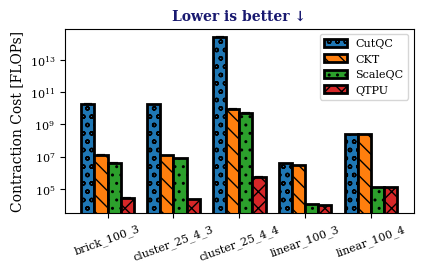

In [ ]:
benches_to_plot = [
    # f"qaoa_erdos_{NUM_QUBITS}_1",
    # f"qaoa_regular_{NUM_QUBITS}_1",
    # f"qaoa_power_{NUM_QUBITS}_1"
    "cluster_25_4_5",
    "cluster_25_4_4",
    "cluster_25_4_3",
    # "cluster_25_4_2",
    # # "cluster_25_4_1",
    # # "cluster_25_8_4",
    # # # "linear_200_1",
    # # "linear_100_2",
    "linear_100_3",
    "linear_100_4",
    # f"random_{NUM_QUBITS}_1",
    # f"random_{NUM_QUBITS}_2",
    # f"random_{NUM_QUBITS}_3",
    # f"random_{NUM_QUBITS}_4",
    # # # # "brick_100_1",
    # # "brick_100_2",
    "brick_100_3",
    "brick_100_4",
]


# df = pd.read_csv(CSV_FILE)
# df = df[df["name"].isin(benches_to_plot)]

# df = df.groupby("name").mean()


# # df.set_index(df.index.str.replace(f"_{NUM_QUBITS}_", "_"), inplace=True)
# # reorder columns
# # df = df[["qtpu", "scaleqc", "ckt", "cutqc"]]
WIDE_FIGSIZE = (4.5, 2.4)

fig, ax = plt.subplots(figsize=WIDE_FIGSIZE)
plot(benches_to_plot, ax)
# ax.set_ylim(0, 1e10)



ax.legend()

# import seaborn as sns

# colors = sns.color_palette("tab10", n_colors=4)

# df.plot.bar(rot=15, width=0.8, edgecolor="black", linewidth=2, ax=ax, color=colors, legend=False)

# # for ytick in ax.get_yticklabels():
# # ytick.set_text(f"$10^{{{ytick.get_text()}}}$")

# ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
# ax.set_title("Lower is better", fontweight="bold", color="midnightblue")
# ax.set_xlabel("")
# fig;

In [ ]:
fig.savefig("cost.pdf", bbox_inches="tight")